# Model prototypes
**Author:** Scott Campit

## Summary
This code is aimed to perform image segmentation.

## 1. Import libraries

In [1]:
# Base libraries
import sys
import numpy as np
import json
import itertools
import random
import os
import random

# Deep learning libraries
import keras
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

# Computer vision libraries
import cv2
import PIL.Image as Image
from skimage import io
import supervisely_lib as sly

# Data visualization libraries
from pylab import rcParams
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

## 2. Read in the data
The Supervise.ly data has been preprocessed in the `make_tf_data.ipynb` notebook so that it is Tensorflow compatible.

In [2]:
# Path to data
IMAGE_SHAPE = (128, 128, 3)
trainpath = "D:/Data/InterOp/TF/train_04092021"
testpath = "D:/Data/InterOp/TF/test_04092021"

train = tf.data.experimental.load(path=trainpath, 
                                  element_spec={'image': tf.TensorSpec(shape=IMAGE_SHAPE, 
                                                                       dtype=tf.float32, 
                                                                       name=None),
                                                'segmentation_mask': tf.TensorSpec(shape=IMAGE_SHAPE,
                                                                                   dtype=tf.uint8, 
                                                                                   name=None)})
test = tf.data.experimental.load(path=testpath, 
                                 element_spec={'image': tf.TensorSpec(shape=IMAGE_SHAPE, 
                                                                      dtype=tf.float32, 
                                                                      name=None),
                                              'segmentation_mask': tf.TensorSpec(shape=IMAGE_SHAPE,
                                                                                 dtype=tf.uint8, 
                                                                                 name=None)})

## 3. Perform data preprocessing

In [3]:
dataset = {"train":train, "val":test}
IMG_SIZE = (128, 128)

We should also create a function that re-casts the data as a tuple.

In [4]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask

In [5]:
@tf.function
def load_train_data(data: dict) -> tuple:
    img  = tf.image.resize(data['image'], IMG_SIZE)
    mask = tf.image.resize(data['segmentation_mask'], IMG_SIZE)
    # Flipping augmentation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    img, mask = normalize(img, mask)
    return img, mask

In [6]:
@tf.function
def load_test_data(data: dict) -> tuple:
    img  = tf.image.resize(data['image'], IMG_SIZE)
    mask = tf.image.resize(data['segmentation_mask'], IMG_SIZE)
    img, mask = normalize(img, mask)
    return img, mask

The dataset is already split into train and test, so we'll initiate some hyperparameters.

In [7]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
SEED = 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Now let's apply it to the dataset

In [8]:
# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_test_data)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>


Let's perform the data augmentation on the training set.

## 4. Visualize an image
We'll create a function that will let us visualize the data.

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Now let's look at an image example.

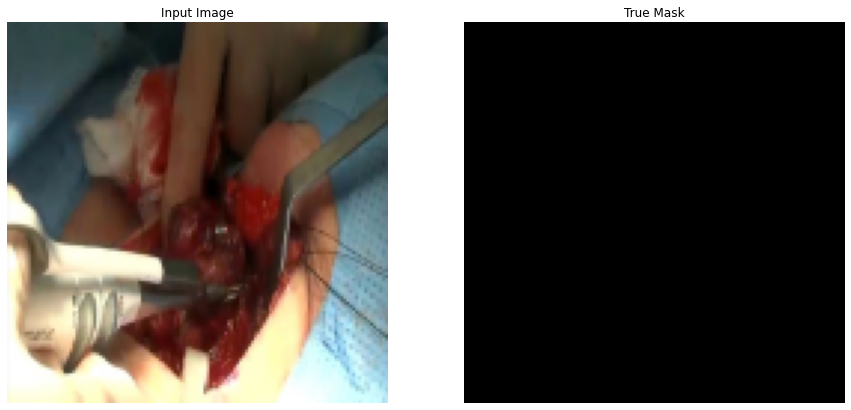

In [10]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
display([sample_image[0], sample_mask[0]])

## 5. Define the model
Now we'll define the model architecture.

#### Determine the number of output classes
First, we'll set the number of labels that are possible.

In [11]:
meta = "D:/Data/InterOp/Sling Health/meta.json"
f = open(meta)
data = json.load(f)
f.close()

# Grab unique classes in the meta data
ids = []
for i in range(len(data['classes'])):
    ids.append(data['classes'][i]['title'])
print(len(ids))

12


In [12]:
# Number of unique classes from the classification task
OUTPUT_CHANNELS = 3#len(ids)

We'll use the MobileNet model for image segmentation.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

We'll grab the decoder.

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Now let's set the UNET model.

In [15]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, 
      kernel_size=3, 
      strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# 3. Train the model
Now let's train the model

In [16]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

Let's see what the models predict before training

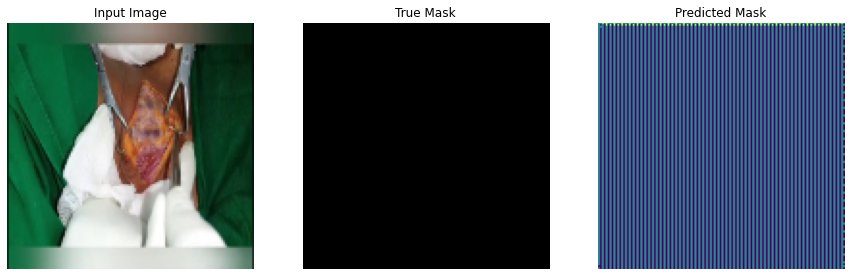

In [17]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], true_mask, create_mask(pred_mask)])
    else:
        one_img_batch = sample_image[0][tf.newaxis, ...]
        inference = model.predict(one_img_batch)
        pred_mask = create_mask(inference)
        display([sample_image[0], 
                 sample_mask[0],
                 pred_mask[0]])
# Show the predictions  
for image, mask in dataset['train'].take(10):
    sample_image, sample_mask = image, mask                  
show_predictions()

Now let's create a callback that let's us see how the model does while training.

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Initialize some hyperparams

In [19]:
EPOCHS = 5
VAL_SUBSPLITS=5
VALIDATION_STEPS = len(test)//BATCH_SIZE//VAL_SUBSPLITS

Finally, let's fit the model.

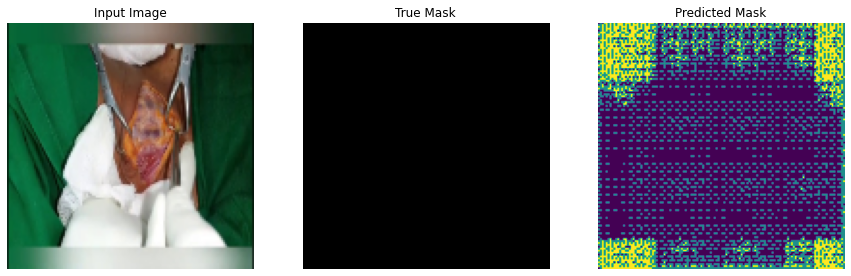


Sample Prediction after epoch 5



In [20]:
model_history = model.fit(dataset['train'], 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['train'],
                          callbacks=[DisplayCallback()])

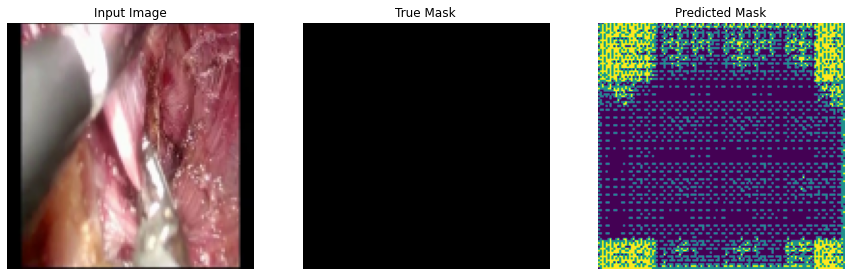

In [24]:
for image, mask in dataset['train'].take(7):
    sample_image, sample_mask = image, mask                  
show_predictions()

And now let's visualize the cost curve.

In [21]:
loss     = model_history.history['loss']
val_loss = model_history.history['val_loss']

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#rc('font',**{'family':'serif','serif':['Times']})

epochs = range(EPOCHS)

plt.figure()
#plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
#ax.plot(epochs, acc, 'ko', label='Accuracy')
plt.bar(epochs, acc, label="Accuracy")
plt.title('Training and Validation Loss', loc='left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

NameError: name 'acc' is not defined

And now visualize the accuracy as a function of model training.

Text(0, 0.5, 'Accuracy')

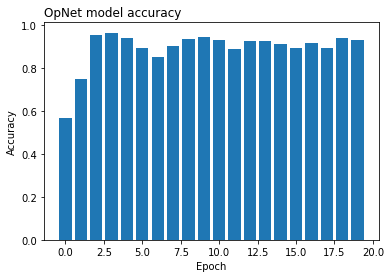

In [34]:
acc = model_history.history['accuracy']
plt.bar(epochs, acc, label="Accuracy")
plt.title('OpNet model accuracy', loc='left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')